# Introduction aux processus gaussiens

Date: 6 février 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

from tinygp import kernels
from tinygp import GaussianProcess

kernel = kernels.ExpSquared(scale=1.5)

import jax.numpy as jnp
import numpyro

import sys
# sys.path.append('../')

from astropy.timeseries import LombScargle
from astropy.table import Table
from jaxoplanet.orbits import keplerian
from jaxoplanet.units import unit_registry as ureg
from numpyro import distributions as dist, infer
from jax import jit  # Ensure JIT is imported

import yaml

In [2]:
data_tbl = Table.read('lbl2_NIRPS_GJ3090_GJ3090_preprocessed.rdb', format='rdb')
time, dTemp, err_dTemp = data_tbl['rjd'], data_tbl['DTEMP3500'], data_tbl['sDTEMP3500']

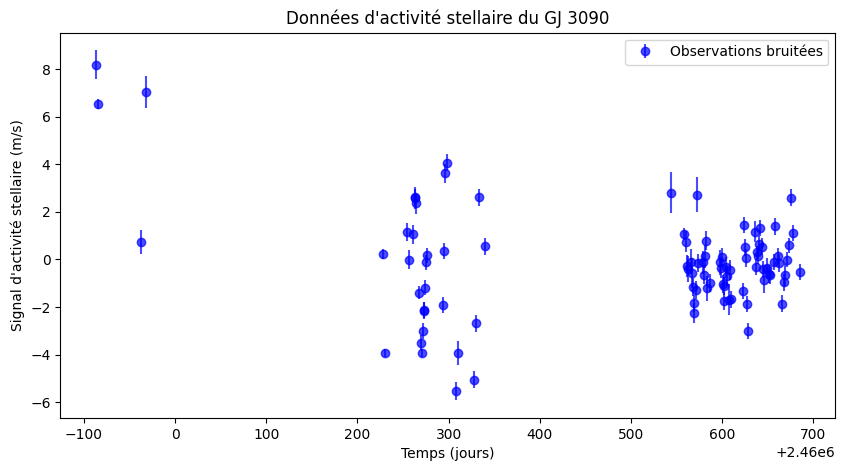

In [3]:
# Affichage des données simulées
plt.figure(figsize=(10, 5))
plt.errorbar(time, dTemp, yerr= err_dTemp, fmt='o', label="Observations bruitées", color='b', alpha=0.7)
plt.xlabel("Temps (jours)")
plt.ylabel("Signal d'activité stellaire (m/s)")
plt.title("Données d'activité stellaire du GJ 3090")
plt.legend()
plt.show()

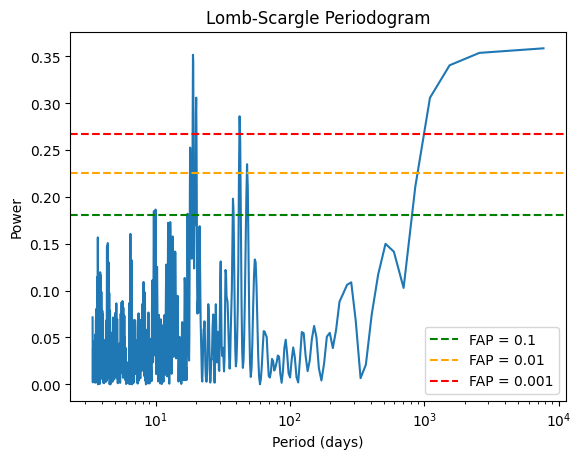

In [4]:

frequency, power = LombScargle(time, dTemp, err_dTemp).autopower()
# Calculate the period from the frequency
period = 1 / frequency
# Calculate the false alarm probability (FAP) levels
fap_levels = [0.1, 0.01, 0.001]
fap_lines = LombScargle(time, dTemp, err_dTemp).false_alarm_level(fap_levels)
plt.figure()
plt.plot(period, power)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.xscale('log')
fap_colors = ['green', 'orange', 'red']
for fap, line in zip(fap_levels, fap_lines):
    plt.axhline(y=line, linestyle='--', label=f'FAP = {fap}',
color=fap_colors.pop(0))
plt.legend()
plt.show()

Nous allons créer un GP qui va tenter de modéliser ce signal d'activité. 

In [5]:
import jax.numpy as jnp

# GP quasi-périodique
def build_gp(theta, time):
    """
    Build a Gaussian Process with a quasi-periodic kernel for stellar activity in RV data.

    Parameters:
        theta (dict): A dictionary of parameters for the kernel and GP.
            Keys:
                - "log_amp" (float): Logarithm of the amplitude of the GP.
                - "log_scale" (float): Logarithm of the scale length for the smooth component.
                - "log_period" (float): Logarithm of the periodic component's period.
                - "log_gamma" (float): Logarithm of the decay timescale for the periodic component.
                - "log_diag" (float): Logarithm of the diagonal noise term.
                - "mean" (float): Mean value of the GP.
        time (array-like): Array of time points for the RV data.

    Returns:
        GaussianProcess: A GaussianProcess object with the quasi-periodic kernel.
    """
    # Extract parameters and transform to positive space where needed
    amp = jnp.exp(theta["log_amp"]) #amplitude du signal d'activité [m/s]
    scale = jnp.exp(theta["log_scale"]) #relié au temps de vie des tâches [jours]
    period = jnp.exp(theta["log_period"]) #période de rotation de l'étoile [jours]
    gamma = jnp.exp(theta["log_gamma"]) #relié au nombre de tâche stellaire 
    diag = jnp.exp(theta["log_diag"]) #modèle du white noise [m/s]
    mean = theta["mean"] #moyenne du signal [m/s]

    # Define the quasi-periodic kernel
    kernel = (
        amp
        * kernels.ExpSquared(scale)
        * kernels.ExpSineSquared(scale=period, gamma=gamma)
    )

    # Build the Gaussian Process
    gp = GaussianProcess(kernel, time, diag=diag, mean=mean)

    return gp

### **Comment trouver les hyperparamètres ayant le mieux avec les données...?** 

À vous de jouer! 

In [6]:
numpyro.set_host_device_count(20)
jax.config.update("jax_enable_x64", True)

In [30]:
def jax_model(time, y_obs=None, y_err=None):

    log_amp = numpyro.sample('log_amp', dist.Uniform(jnp.log(4), jnp.log(12)))
    log_scale = numpyro.sample('log_scale', dist.Uniform(jnp.log(9), jnp.log(90)))
    log_period = numpyro.sample('log_period', dist.Uniform(jnp.log(15), jnp.log(20)))
    log_gamma =  numpyro.sample('log_gamma', dist.Uniform(jnp.log(0.1), jnp.log(10)))
    log_diag = numpyro.sample('log_diag', dist.Uniform(jnp.log(0.01), jnp.log(10)))
    mean = numpyro.sample('mean', dist.Uniform(-10, 10))

    params = {
        "log_amp": log_amp, "log_scale": log_scale, "log_period": log_period, "log_gamma": log_gamma,
        "log_diag": log_diag, "mean": mean,
    }

    # Expected value
    gp = build_gp(params, time)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs= y_obs)

In [31]:
init_values = {
    "log_amp": jnp.log(6),
    "log_scale": jnp.log(50),
    "log_period": jnp.log(18.2),
    "log_gamma": jnp.log(3),
    "log_diag": jnp.log(1),
    "mean": np.float64(0),
}

In [32]:
nuts_model = infer.NUTS(jax_model,  dense_mass = True, regularize_mass_matrix = False, init_strategy=infer.init_to_value(values=init_values))

In [33]:
# Define the number of warm-up steps, samples, and chains
ndim = 6
num_warmup = ndim * 100
num_samples = ndim * 1000
num_chains = 2

# Use NUTS sampler with initialization strategy set to predefined values
nuts_model = infer.NUTS(jax_model, init_strategy = infer.init_to_value(values=init_values))

sampler = infer.MCMC(
    nuts_model,  # Initialize with the defined initial values
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    progress_bar=True,
)

# Ensure random seed is provided and compatible with JAX
seed = jax.random.PRNGKey(6)

# Run the sampler on the model with time and observed RV data
sampler.run(seed, time, y_obs = dTemp, y_err = err_dTemp)

# Summarize the results
sampler.print_summary()

  0%|          | 0/6600 [00:00<?, ?it/s]

  0%|          | 0/6600 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     log_amp      2.06      0.26      2.08      1.70      2.48   8371.08      1.00
    log_diag     -0.51      0.26     -0.52     -0.95     -0.08   7881.00      1.00
   log_gamma      0.40      0.41      0.41     -0.31      1.03   8182.59      1.00
  log_period      2.91      0.02      2.91      2.88      2.94   8017.39      1.00
   log_scale      3.95      0.22      3.94      3.60      4.33   7053.24      1.00
        mean      1.03      1.01      1.01     -0.71      2.59  12956.05      1.00

Number of divergences: 0


In [34]:
samples = sampler.get_samples()
best_params = {k: jnp.median(v) for k, v in samples.items()}
print(best_params)

{'log_amp': Array(2.08393309, dtype=float64), 'log_diag': Array(-0.51579514, dtype=float64), 'log_gamma': Array(0.40754412, dtype=float64), 'log_period': Array(2.90555659, dtype=float64), 'log_scale': Array(3.94021426, dtype=float64), 'mean': Array(1.01458078, dtype=float64)}


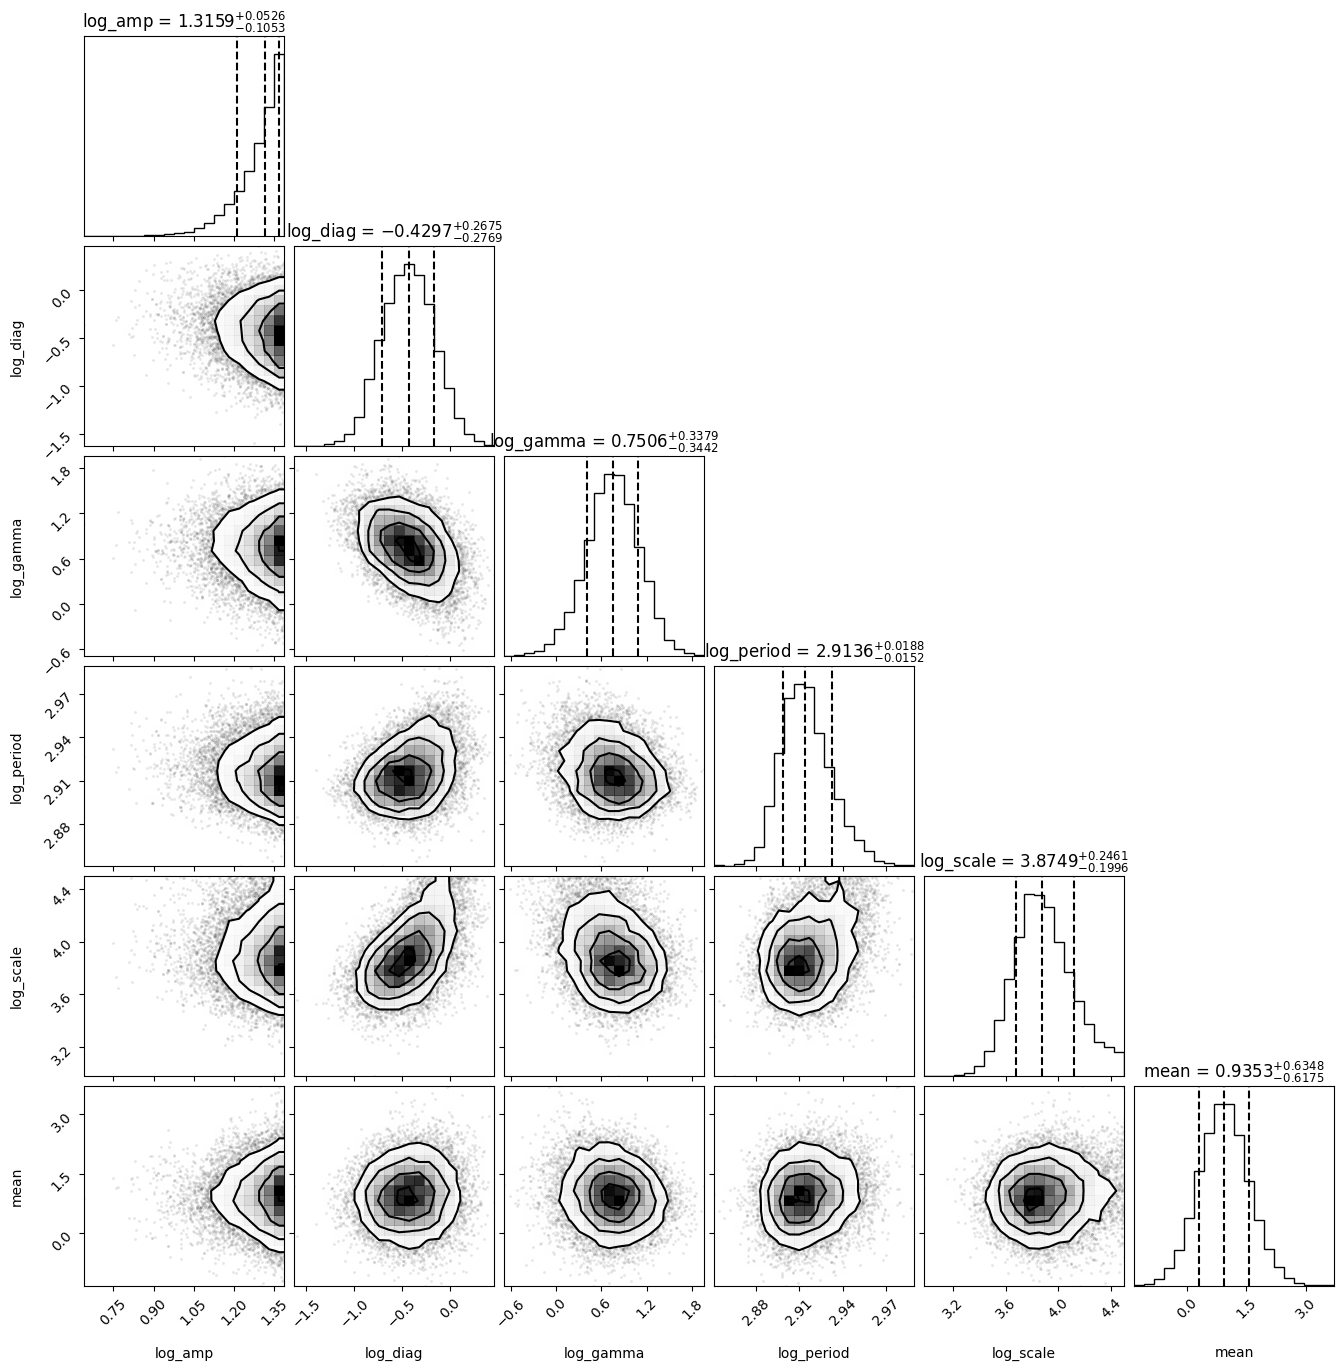

In [28]:
import corner

_ = corner.corner(
    samples,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
)

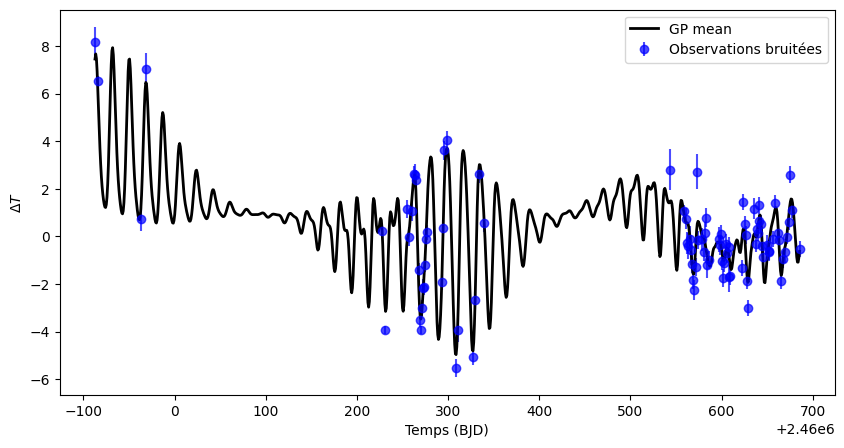

In [29]:
# Plot the predicted GP mean and variance
tsmooth = jnp.linspace(time.min(), time.max(), 1000)

best_gp = build_gp(best_params, time)
mu = best_gp.predict(dTemp, tsmooth)

plt.figure(figsize=(10, 5))
plt.errorbar(time, dTemp, yerr=err_dTemp, fmt='o', label="Observations bruitées", color='b', alpha=0.7)
plt.plot(tsmooth, mu, label="GP mean", color='k', linewidth=2)
#plt.fill_between(tsmooth, mu - 2 * std, mu + 2 * std, color='k', alpha=0.2, label="GP 2σ interval")
plt.xlabel("Temps (BJD)")
plt.ylabel(r"$\Delta T$")
plt.legend()
plt.show()

# part 3 

In [ ]:
star_name = 'GJ3090'
instrument = 'NIRPS'
activity = 'GJ3090_preprocessed'

tbl = Table.read(f'lbl2_{instrument}_{star_name}_{activity}.rdb', format='rdb') 
#get the file from the directory

time = tbl['rjd'] * ureg.days #reduced julian day
rv_obs = tbl['vrad'] * ureg.meter / ureg.second #vitesse radiale
rv_err = tbl['svrad'] * ureg.meter / ureg.second #incertitudes
err_guess = np.median(rv_err)

In [ ]:
star = keplerian.Central(mass=0.519 * (1.9891 * 10**30), radius=0.516 * (696340))